### Data Loading Demo

This notebook shows some of the steps required to load the first break picking data (gathers and
annotations) to be used to train predictive models.

We assume that the raw data (`.hdf5.xz` files) is available in a `data` directory located
next to this notebook. For the links to download this data, refer to the repository's top-level
README file.

In [4]:
# run me once to import all the packages needed for the notebook to run
import collections  # used for namedtuples in site info definitions
import os  # required for path/filesystem stuff
import hashlib  # required for MD5 checksum analysis
import lzma  # required for dataset decompression
import typing  # for typedefs in class/function/args declarations

import h5py  # required for HDF5 file parsing
import matplotlib.pyplot as plt  # used in the last cell to render a gather image
import numpy as np  # all loaded arrays will be provided as numpy arrays
import torch.utils.data  # required for the trace dataset parser class definition

print("HardPicks Demo Notebook v1.0 ready to go!")

data_root_path = os.path.join(os.getcwd(), "data")

HardPicks Demo Notebook v1.0 ready to go!


First, we provide a few high-level parameter structures that are associated with each dataset; these
are useful when parsing the data and making sure it is valid.

In [5]:
SiteInfo = collections.namedtuple(  # each site will be defined using this tuple definition...
    "SiteInfo",
    [
        "site_name",  # the 'name' of the site (for lookup/display/printing)
        "first_break_field_name",  # the name of the HDF5 dataset/field containing the first breaks 
        "hdf5_file_name",  # the original name expected for the HDF5 file itself 
        "md5_checksum",  # the checksum of the original HDF5 file (as of the initial release date)
        "receiver_id_digit_count",  # the number of digits used to identify receivers in the dataset
    ],
)

BRUNSWICK_SITE_INFO = SiteInfo(
    site_name="Brunswick",
    first_break_field_name="SPARE1",
    hdf5_file_name="Brunswick_orig_1500ms_V2.hdf5",
    md5_checksum="3ca7b8d1633ec7cecc07f0eff94dff69",
    receiver_id_digit_count=3,
)

HALFMILE_SITE_INFO = SiteInfo(
    site_name="Halfmile",
    first_break_field_name="SPARE1",
    hdf5_file_name="Halfmile3D_add_geom_sorted.hdf5",
    md5_checksum="dc7b0d181b8b81109a7e2e0ad60fa391",
    receiver_id_digit_count=4,
)

LALOR_SITE_INFO = SiteInfo(
    site_name="Lalor",
    first_break_field_name="SPARE2",
    hdf5_file_name="Lalor_raw_z_1500ms_norp_geom_v3.hdf5",
    md5_checksum="d3c4722ef791cc3ec5adab656b16b925",
    receiver_id_digit_count=3,
)

SUDBURY_SITE_INFO = SiteInfo(
    site_name="Sudbury",
    first_break_field_name="SPARE1",
    hdf5_file_name="preprocessed_Sudbury3D.hdf",
    md5_checksum="f8772ec3a650820db3da1c8936f6945c",
    receiver_id_digit_count=3,
)

SITE_INFO_ARRAY = [
    SUDBURY_SITE_INFO,
    HALFMILE_SITE_INFO,
    BRUNSWICK_SITE_INFO,
    LALOR_SITE_INFO,
]

print("Site info structures initialized.")

Site info structures initialized.


We will now scan the data directory for all the dataset files and uncompress them if any are found
and not yet uncompressed. Note that the total sized of the uncompressed files that will be created
is around 45 GB.

In [6]:
def get_md5_hash(file_path):
    hash_md5 = hashlib.md5()
    with open(file_path, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()

dataset_file_names = [p for p in os.listdir(data_root_path) if ".hdf" in p]
dataset_file_paths = [os.path.join(data_root_path, p) for p in dataset_file_names]
assert len(dataset_file_paths) > 0, f"could not locate any hdf5 file in: {data_root_path}"

warned_already = False
for dataset_file_path in dataset_file_paths:
    assert any([dataset_file_path.endswith(s) for s in [".xz", ".hdf", ".hdf5"]])
    if dataset_file_path.endswith(".xz"):
        uncompr_dataset_path = dataset_file_path.split(".xz")[0]
        if not os.path.exists(uncompr_dataset_path):
            print(f"Decompressing dataset: {uncompr_dataset_path}")
            if not warned_already:
                print("\tnote: this can take several minutes per dataset!")
                warned_already = True
            with lzma.open(dataset_file_path) as lzfd:
                with open(uncompr_dataset_path, "wb") as outfd:
                    for chunk in iter(lambda: lzfd.read(4096), b""):
                        outfd.write(chunk)

for site_info in SITE_INFO_ARRAY:
    print(f"Validating MD5 for {site_info.site_name}...")
    data_file_path = os.path.join(data_root_path, site_info.hdf5_file_name)
    assert os.path.isfile(data_file_path), f"could not locate HDF5 file: {data_file_path}"
    curr_hash = get_md5_hash(data_file_path)
    assert curr_hash == site_info.md5_checksum, "checksum validation failed"

print("All datasets validated and ready-to-go.")

Validating MD5 for Lalor...
All datasets validated and ready-to-go.


The traces and first break annotations are contained in the HDF5 files that are now ready to be
parsed. The HDF5 file holds this data under the "TRACE_DATA/DEFAULT" group. Below is the complete
list of data that are expected to be present under different field names. The function also provided
below will make sure all these fields are present.

In [7]:
BASE_EXPECTED_HDF5_FIELDS = [
    "REC_PEG",  # PEG identifiers for the receivers (one entry per trace)
    "REC_X",  # X coordinate of the receivers (one entry per trace)
    "REC_Y",  # Y coordinate of the receivers (one entry per trace)
    "REC_HT",  # height/elevation of the receivers (one entry per trace)
    "SAMP_NUM",  # sample counts (one entry per trace, but should be constant)
    "SAMP_RATE",  # sampling rates (one entry per trace, but should be constant)
    "COORD_SCALE",  # scale factors to be applied to coordinates (one entry per trace, but should be constant)
    "HT_SCALE",  # scale factors to be applied to heights/evalations (one entry per trace, but should be constant)
    "SHOTID",  # shot identifiers (one entry per trace)
    "SHOT_PEG",  # shot PEG identifiers (one entry per trace)
    "SOURCE_X",  # X coordinate of the shot location (one entry per trace)
    "SOURCE_Y",  # Y coordinate of the shot location (one entry per trace)
    "SOURCE_HT",  # height/elevation of the shot location (one entry per trace)
    "data_array",  # 2D array of all recorded seismic traces (trace count x sample count)
]


def check_h5data_struct(h5root: h5py.Group, expected_hdf5_fields: typing.List[str]) -> None:
    """Parses the top-level hdf5 objects and validates the dataset structure."""
    assert "TRACE_DATA" in h5root, "unexpected root level hdf5 structure"
    assert "DEFAULT" in h5root["TRACE_DATA"], "unexpected root level hdf5 structure"
    h5data = h5root["TRACE_DATA"]["DEFAULT"]
    expected_trace_count = None
    for expected_field in expected_hdf5_fields:
        assert (
            expected_field in h5data
        ), f"missing field {expected_field} in HDF5 file"
        if expected_trace_count is None:
            expected_trace_count = len(h5data[expected_field])
        else:
            assert expected_trace_count == len(h5data[expected_field]), (
                f"unexpected dataset size for field {expected_field}\n"
                f"\t({len(h5data[expected_field])} instead of {expected_trace_count})"
            )

for site_info in SITE_INFO_ARRAY:
    print(f"Checking HDF5 structure for {site_info.site_name}...")
    data_file_path = os.path.join(data_root_path, site_info.hdf5_file_name)
    expected_hdf5_fields = BASE_EXPECTED_HDF5_FIELDS + [site_info.first_break_field_name]
    with h5py.File(data_file_path, mode="r") as h5fd:
        check_h5data_struct(h5fd, expected_hdf5_fields)

print("All datasets checked for HDF5 structure and fields.")

Checking HDF5 structure for Lalor...
All datasets checked for HDF5 structure and fields.


Since all the datasets have a common structure, we should define a 'parser' class to encapsulate
the parsing logic; we do that below using the PyTorch dataset interface. See the docstring in
that class for more information.

In [8]:
class TraceDataset(torch.utils.data.Dataset):
    """Container for raw FBP trace data read directly from an HDF5 file.

    The `size` of this parser will be equal to the total number of traces in the dataset. Each trace
    in the dataset will be assigned a unique identifier (an integer between 0 and SIZE-1) making it
    possible to directly iterate over all traces. The `__getitem__` function will return a
    dictionary of all the data associated with a particular trace.
    
    The class attributes detailed below with the `_map` suffix can be used to assemble gathers. This
    parser may not be very efficient for the generation of images however, so if you intend on
    training models for a while, you might want to consider wrapping it and caching its results. 

    Attributes:
        receiver_id_digit_count: defines how many digits will be imputed to the receiver ids in
            the encoded receiver peg number.
        first_break_field_name: The variable name in the HDF5 file where the picks are stored.
        total_trace_count: the total number of traces (equal to the number of deployed receivers).
        trace_to_shot_map: maps all trace IDs to their corresponding unique shot ID.
        shot_to_trace_map: maps all shot IDs to their corresponding list of trace IDs.
        trace_to_line_map: maps all trace IDs to their corresponding unique receiver line ID.
        line_to_trace_map: maps all receiver line IDs to their corresponding list of trace IDs.
        trace_to_rec_map: maps all trace IDs to their corresponding unique receiver ID.
        rec_to_trace_map: maps all receiver IDs to their corresponding list of trace IDs.
        trace_to_gather_map: maps all trace IDs to their corresponding unique line gather ID.
        gather_to_trace_map: maps all line gather IDs to their corresponding list of trace IDs.
        samp_num: the number of seismic samples recorded per trace.
        samp_rate: the sampling rate of receivers (in microseconds).
        first_break_labels: the sample indices that were picked as the 'first break' by an
            annotator or automated tool. There is one value per trace.
        first_break_timestamps: the timestamps (in milliseconds) that were picked as the 'first
            break' by an annotator or automated tool. There is one value per trace.
        coord_scale: scaling factor to be applied to the parsed receiver/shot X and Y coordinates to
            get their real coordinates.
        ht_scale: scaling factor to be applied to the parsed receiver/shot Z (height) coordinate to
            get their real coordinates.
        shot_to_coords_map: maps all shot IDs to their corresponding 3d coordinates (X,Y,Z).
        rec_to_coords_map: maps all receiver IDs to their corresponding 3d coordinates (X,Y,Z).
    """

    BAD_FIRST_BREAK_PICK_INDEX = 0  # this constant is used as a way to flag 'bad' annotations

    def __init__(
        self,
        hdf5_path: typing.AnyStr,
        receiver_id_digit_count: int,  # the digit count allocated for IDs in the rec peg number
        first_break_field_name: typing.AnyStr,  # the variable name in the HDF5 file where the picks are stored
    ):
        """Building the object will actually open and parse the hdf5 archive."""
        print(f"Parsing HDF5 file at: {hdf5_path}")
        with h5py.File(hdf5_path, mode="r") as h5root:
            h5data = h5root["TRACE_DATA"]["DEFAULT"]
            self.receiver_id_digit_count = receiver_id_digit_count
            self.first_break_field_name = first_break_field_name
            self.hdf5_path = hdf5_path
            self.samp_num = self._get_const_parameter(h5data, "SAMP_NUM")
            self.samp_rate = self._get_const_parameter(h5data, "SAMP_RATE")  # in usec (typically?)
            self.max_fb_timestamp = self.samp_num * self.samp_rate / 1000  # in msec (based on above?)
            self.coord_scale = self._get_const_parameter(h5data, "COORD_SCALE")
            self.ht_scale = self._get_const_parameter(h5data, "HT_SCALE")
            self.total_trace_count = len(h5data["data_array"])
            print(f"\tfound {self.total_trace_count} traces")
            self.trace_to_shot_map, self.shot_to_trace_map = self._get_id_maps(
                h5data, "SHOT_PEG", decode_peg_id=True, id_digit_count=0
            )  # no need for digit count
            print(f"\tfound {len(self.shot_to_trace_map)} shots")
            self.trace_to_rec_map, self.rec_to_trace_map = self._get_id_maps(
                h5data,
                "REC_PEG",
                decode_peg_id=False,
                id_digit_count=receiver_id_digit_count,
            )
            print(f"\tfound {len(self.rec_to_trace_map)} receivers")
            self.trace_to_line_map, self.line_to_trace_map = self._get_id_maps(
                h5data,
                "REC_PEG",
                decode_peg_id=True,
                id_digit_count=receiver_id_digit_count,
            )
            print(f"\tfound {len(self.line_to_trace_map)} receiver lines")
            self.trace_to_gather_map, self.gather_to_trace_map = self._get_gather_maps()
            # note: number of 'line gathers' = number of receiver lines x number of shots
            print(f"\tfound {len(self.gather_to_trace_map)} line gathers")

            self.first_break_labels, self.first_break_timestamps = self._get_first_breaks(
                h5data, self.first_break_field_name
            )
            self.rec_to_coords_map = self._get_coords(h5data, "REC")
            self.shot_to_coords_map = self._get_coords(h5data, "SHOT")
        self._h5fd = None  # will be set in the first getitem function call for later queries

    @staticmethod
    def _get_id_maps(
        h5data: h5py.Group,
        peg_name: typing.AnyStr,
        decode_peg_id: bool,
        id_digit_count: int,
    ) -> typing.Tuple[typing.Sequence[int], typing.Dict[int, typing.Sequence[int]]]:
        """Returns both the trace-to-id and id-to-trace mappings for receivers or shots."""
        assert peg_name in ["SHOT_PEG", "REC_PEG"], "unexpected peg type"
        # convert to np.int32 from np.uint32 because pytorch cannot handle unsigned integers:
        # since we'll feed this into pytorch eventually, it's better to snip this problem in the bud
        pegs = np.array(h5data[peg_name]).flatten().astype(np.int32)
        if decode_peg_id:
            if peg_name == "SHOT_PEG":
                if np.unique(h5data["SHOT_PEG"]).size == 1:
                    # pegs are sometimes broken (e.g. in the sudbury site), swap to SHOTID in that case
                    pegs = np.array(h5data["SHOTID"]).flatten().astype(np.int32)
                else:
                    assert np.unique(h5data["SHOT_PEG"]).size == np.unique(h5data["SHOTID"]).size
                ids = pegs  # for shots, we can keep the full peg as the identifier (same result)
            else:  # peg_name == "REC_PEG"
                # for receiver pegs, the ID we want to keep is only the first few (base-10) digits
                ids = pegs // (10 ** id_digit_count)
        else:
            ids = pegs
        reversed_map = {sid: np.where(ids == sid)[0].astype(np.int32) for sid in np.unique(ids)}
        assert sum([len(idxs) for idxs in reversed_map.values()]) == len(pegs), "bad reverse map impl"
        return ids, reversed_map

    def _get_gather_maps(
        self,
    ) -> typing.Tuple[typing.Sequence, typing.Dict[int, typing.Sequence[int]]]:
        """Returns both the trace-to-gather and gather-to-trace mappings for the dataset."""
        gather_to_trace_map = {}
        trace_to_gather_map = [None] * self.total_trace_count
        # first, double-loop on shot+traces to find intersections
        for shot_id, shot_traces in self.shot_to_trace_map.items():
            for line_id, line_traces in self.line_to_trace_map.items():
                gather_traces = np.intersect1d(shot_traces, line_traces)
                if not len(gather_traces):
                    continue
                next_gather_id = len(gather_to_trace_map)
                gather_to_trace_map[next_gather_id] = gather_traces
        # now, reloop over all gathers to assign ids in the direct map
        for gather_id, gather_traces in gather_to_trace_map.items():
            for trace_id in gather_traces:
                assert 0 <= trace_id < self.total_trace_count, "bad trace id found in gather?"
                assert trace_to_gather_map[trace_id] is None, "trace had multiple intersections?"
                trace_to_gather_map[trace_id] = gather_id
        assert not any([t is None for t in trace_to_gather_map]), "there are useless traces?"
        return trace_to_gather_map, gather_to_trace_map

    @staticmethod
    def _get_const_parameter(
        h5data: h5py.Group,
        field_name: typing.AnyStr
    ) -> np.number:
        """Returns a constant-across-all-traces parameter from the HDF5 group."""
        data = np.unique(h5data[field_name])
        assert len(data) == 1, f"invalid field {field_name} (content not unique)"
        return data[0]

    def _get_first_breaks(
        self,
        h5data: h5py.Group,
        field_name: typing.AnyStr,
    ) -> typing.Tuple[typing.Sequence[int], typing.Sequence[float]]:
        """Returns the maps of label indices and timestamps for first break picks."""
        assert self.samp_num > 0 and self.samp_rate > 0, "invalid sample rate/count values"
        assert self.samp_num == h5data["data_array"].shape[-1], "bad trace data sample count"
        assert self.samp_rate >= 1000, "current impl assumes rate is provided in usec, still true?"
        # we'll assume that fddata contains traces in msec, so we have to use the rate to convert
        fbdata_msec = np.array(h5data[field_name]).flatten()
        assert len(fbdata_msec) == self.total_trace_count, "unexpected first break data array shape"
        samp_rate_msec = self.samp_rate / 1000.0
        bad_fb_picks = np.where(fbdata_msec <= self.BAD_FIRST_BREAK_PICK_INDEX)
        fbdata_idxs = self._get_first_break_indices(fbdata_msec, samp_rate_msec)
        fbdata_idxs[bad_fb_picks] = -1
        assert (fbdata_idxs < self.samp_num).all(), "are picks really provided in msec?"
        return fbdata_idxs, fbdata_msec

    @staticmethod
    def _get_first_break_indices(
        fbp_times_in_milliseconds: np.ndarray,
        sample_rate_in_milliseconds: float,
    ) -> np.ndarray:
        """Returns the first break pick sample indices based on the annotations given in msec."""
        ratio = fbp_times_in_milliseconds / sample_rate_in_milliseconds
        small_ratio_mask = np.bitwise_and(ratio > 0., ratio <= 1.)
        fbp_indices = np.floor(ratio)
        # make sure that small first break picks are not assigned to zero, which are flagged as abnormal.
        fbp_indices[small_ratio_mask] = 1
        return fbp_indices.astype(np.int32)

    def _get_coords(
        self,
        h5data: h5py.Group,
        target_set: typing.AnyStr
    ) -> typing.Dict[int, typing.Sequence[float]]:
        """Returns the map of coordinates for either receivers or shots (based on `target_set`)."""
        assert target_set in ["REC", "SHOT"], "unexpected coords target set"
        if target_set == "REC":
            target_fields = ["REC_X", "REC_Y", "REC_HT"]
            target_map = self.rec_to_trace_map
        else:
            target_fields = ["SOURCE_X", "SOURCE_Y", "SOURCE_HT"]
            target_map = self.shot_to_trace_map
        coords = np.stack([np.array(h5data[field]).flatten() for field in target_fields], axis=1)
        xy_scale, z_scale = (np.abs(float(self.coord_scale)), np.abs(float(self.ht_scale)))
        coords = (coords / np.asarray((xy_scale, xy_scale, z_scale))).astype(np.float32)
        out_coords_map = {}
        for target_id, trace_ids in target_map.items():
            unique_coords = np.unique(coords[trace_ids], axis=0)
            if len(unique_coords) > 1:
                # yes, it can sometimes happen, we just need to make sure it's only due to fp error
                assert [
                    np.allclose(unique_coords[0], unique_coords[i])
                    for i in range(1, len(unique_coords))
                ], "unexpected coordinate variation inside group"
            out_coords_map[target_id] = unique_coords[0]
        return out_coords_map

    def __len__(self):
        """Returns the total number of traces in the dataset."""
        return self.total_trace_count

    def __getitem__(self, trace_id):
        """Returns a dictionary containing all pertinent information for a particular trace."""
        assert 0 <= trace_id < self.total_trace_count, "trace query index is out-of-bounds"
        # for efficient gather-level parsing, a derived class should bypass this call entirely...
        rec_id = self.trace_to_rec_map[trace_id]
        shot_id = self.trace_to_shot_map[trace_id]
        if self._h5fd is None:
            self._h5fd = h5py.File(self.hdf5_path, mode="r")
        samples = self._h5fd["TRACE_DATA"]["DEFAULT"]["data_array"][trace_id]
        assert len(samples) == self.samp_num
        return dict(  # dictionaries are used here to make sure we can batch results together
            trace_id=trace_id,
            shot_id=shot_id,
            rec_line_id=self.trace_to_line_map[trace_id],
            rec_id=rec_id,
            gather_id=self.trace_to_gather_map[trace_id],
            first_break_label=self.first_break_labels[trace_id],
            first_break_timestamp=self.first_break_timestamps[trace_id],
            rec_coords=self.rec_to_coords_map[rec_id],
            shot_coords=self.shot_to_coords_map[shot_id],
            samples=samples,
            sample_count=int(self.samp_num),
        )

print("Trace dataset parser class declared and ready to be used!")

Trace dataset parser class declared and ready to be used!


We will now instantiate that class once for each dataset that we would like to parse. This may
take a few minutes since each HDF5 file will be opened and scanned for metadata, but the loading
of actual traces will happen later, meaning creating parsers like this will not demand a huge
amount of memory.

In [9]:
dataset_parsers = {}

for site_info in SITE_INFO_ARRAY:
    data_file_path = os.path.join(data_root_path, site_info.hdf5_file_name)
    parser = TraceDataset(
        hdf5_path=data_file_path,
        receiver_id_digit_count=site_info.receiver_id_digit_count,
        first_break_field_name=site_info.first_break_field_name,
    )
    dataset_parsers[site_info.site_name] = parser

print("All dataset parsers ready to load the data!")

Parsing HDF5 file at: /home/stcharlp/dev/nrcan02-hardpicks/data/Lalor_raw_z_1500ms_norp_geom_v3.hdf5
	found 2424923 traces
	found 907 shots
	found 2685 receivers
	found 16 receiver lines
	found 14455 line gathers


The datasets are now ready to be used! As a final step, we show below how to assemble and display
a line gather image using the parser's maps to fetch all the relevant trace IDs.

Lalor has 14455 line gathers; here's #7482:


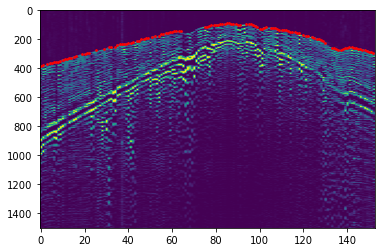

In [99]:
lalor_parser = dataset_parsers["Lalor"]
gather_id = np.random.choice(list(lalor_parser.gather_to_trace_map.keys()))
print(f"Lalor has {len(lalor_parser.gather_to_trace_map)} line gathers; here's #{gather_id}:")
trace_ids = lalor_parser.gather_to_trace_map[gather_id]
trace_data = [lalor_parser[tid] for tid in trace_ids]
# we will stack the seismic amplitudes and normalize them in a trace-wise fashion
trace_array = np.asarray([data["samples"] for data in trace_data])
trace_mean, trace_std = trace_array.mean(axis=1), (trace_array.std(axis=1) + 0.0001)
trace_array = (trace_array - trace_mean.reshape(-1, 1)) / (trace_std * 2.5).reshape(-1, 1)
trace_array = np.clip(trace_array, 0, 1)  # clip to make sure there is good contrast everywhere!
# display the array as an image directly, and draw the picks on top of it
plt.imshow(trace_array.T, aspect="auto")
valid_pick_coords = [
    (idx, d["first_break_label"])
    for idx, d in enumerate(trace_data)
    if d["first_break_label"] > TraceDataset.BAD_FIRST_BREAK_PICK_INDEX
]
if len(valid_pick_coords):
    # if any annotated picks are available, they will be drawn in red
    picks_trace_idxs, picks_sample_idxs = tuple(zip(*valid_pick_coords))
    plt.scatter(x=picks_trace_idxs, y=picks_sample_idxs, c='r', s=3)
plt.show()